In [148]:
#EVERYTHING IN SI UNITS, celcius

%matplotlib inline

from modsim import *

##################THINGS TO CALIBRATE######################
c_r = 60 #Rate of heat transfer from coffee to air (Joules/minute)
c_m = .200 #Mass (kg)

wc_r = 10000 #Rate of heat transfer from coffee to ice (Joules/minute)
c_wc_r = 500

w_r = 4500 #Rate of heat transfer from air to ice (Joules/minute)
w_m = .010 #Mass (kg)

##################INITIAL CONDITIONS######################
c_J_init = State(nrg = 0)
c_T_init = State(temp = 90)


w_J_init = State(nrg = 0)
w_T_init = State(temp = -18.0)

##################SYSTEMS######################
Coffee = System(n = 'Coffee',
               m = c_m, r = c_r, wc_r = c_wc_r,
               J_init = c_J_init, T_init = c_T_init)
#H2O in any form

Water = System(n = 'Water',
               m = w_m, r = w_r, wc_r = wc_r, 
               J_init = w_J_init, T_init = w_T_init)

##################SIMULATION VARIABLES######################
dt = 0.125
t0 = 0
t_end = 20
T_env = 23
t_mix = 0 #For Testing
sweep_range1 = 0
sweep_range2 = t_end

In [126]:
def convert_to_Temp(system):
    unpack(system)
    frame = TimeFrame(columns=T_init.index)
    frame.loc[t0] = State(temp = convert_joules_to_temp(J_init.nrg))
    ts = linrange(t0, t_end, dt)
    for t in ts:
        frame.loc[t+dt] = State(temp=convert_joules_to_temp(Water.results.loc[t].nrg))
    system.newResults = frame
    
def update(state, system):
    """
    Update the thermal transfer model.
    
    state: State (temp)
    system: System object
    
    returns: State (temp)
    """
    unpack(system)
    T = state.temp
    T += -r * (T - T_env) * dt

    return State(temp=T)

def convert_joules_to_temp(j, system):
    """
    Converts joules to temperature for specific system. Different systems 
    are converted differently, which is what the if statement takes care of
    
    j: Current Number of Joules
    system: System object-either ice or coffee
    returns: Temperature of System
    """
    unpack(system)
    if system.n == 'Water':
        t = None
        if(j < 379.44):
            t = (j -379.44) * 18 / 379.44
        elif(j >= 379.44 and j < (379.44 + 33333.33)):
            t = 0
        else:
            t = (j - (379.44+33333.33)) / 963.01 * 23
        return t
    elif system.n == 'Coffee':
        t = T_init.temp - ((J_init.nrg - j)/(m * 4187))
        return t
    
def update(state1,state2,state3,system,t,t_mix):
    """
    Update the thermal transfer model.
    
    state1: Energy of current system
    state2: Temperature of current system
    state3: Temperature of other system
    system: System under observation, either Water or Coffee
    t = current time
    t_mix = time ice was added
    
    returns: State (Energy)
    """
    unpack(system)
    
    J = state1.nrg
    if(t < t_mix or n == 'Coffee'):
        J += -1 * r * m *(state2.temp - T_env) * dt
    if(t >= t_mix):
        J += -1 * wc_r * m *(state2.temp - state3.temp) * dt
    return State(nrg = J)

def run_simulation1(system_w, system_c, update_func, t_mix):
    """
    Runs a simulation of the system.
    
    Add a TimeFrame to the System: results
    
    system_w: Water System
    system_c: Coffee System
    
    update_func: function that updates state
    t_mix: time ice was added
    """
    
    w_frame = TimeFrame(columns=system_w.J_init.index)
    w_frame.loc[t0] = system_w.J_init
    w_frame2 = TimeFrame(columns=system_w.T_init.index)
    w_frame2.loc[t0] = State(temp = convert_joules_to_temp(system_w.J_init.nrg,system_w))   
    c_frame = TimeFrame(columns=system_c.J_init.index)
    c_frame.loc[t0] = system_c.J_init
    c_frame2 = TimeFrame(columns=system_c.T_init.index)
    c_frame2.loc[t0] = State(temp = convert_joules_to_temp(system_c.J_init.nrg,system_c))  
    ts = linrange(t0, t_end, dt)

    for t in ts:
        w_frame.loc[t+dt] = update_func(w_frame.loc[t],w_frame2.loc[t],c_frame2.loc[t], system_w,t,t_mix)
        w_frame2.loc[t+dt] = State(temp=convert_joules_to_temp(w_frame.loc[t].nrg,system_w))
        c_frame.loc[t+dt] = update_func(c_frame.loc[t],c_frame2.loc[t], w_frame2.loc[t],system_c,t,t_mix)
        c_frame2.loc[t+dt] = State(temp=convert_joules_to_temp(c_frame.loc[t].nrg,system_c))
    system_w.results = w_frame
    system_w.newResults = w_frame2
    system_c.results = c_frame
    system_c.newResults = c_frame2
    
def sweep(range1, range2):
    results = TimeSeries()
    for i in linrange(range1, range2):
        t_mix = i
        run_simulation1(Water,Coffee,update,t_mix)
        results[i] = Coffee.newResults.temp[t_end]
    return results
def newSweep(range1,range2):
    results = TimeSeries()
    for i in linrange(range1,range2):
        print()
        

In [127]:
#For Testing
#convert_joules_to_temp(-1800, Coffee)
#convert_temp_to_joules(33333.33+963.01+379.44)
#print (Coffee.newResults.temp)
#print (Coffee.newResults.temp[t_end])

In [149]:
run_simulation1(Water,Coffee,update,t_mix)

In [129]:
sweep = sweep(sweep_range1, sweep_range2)

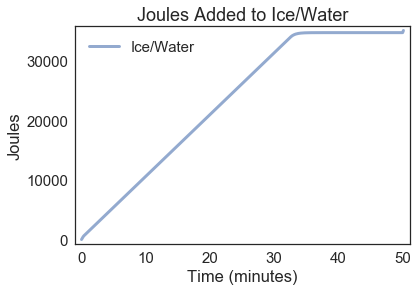

In [138]:
plot(Water.results.nrg, label='Ice/Water')
decorate(xlabel='Time (minutes)',
         ylabel='Joules',
         title='Joules Added to Ice/Water')

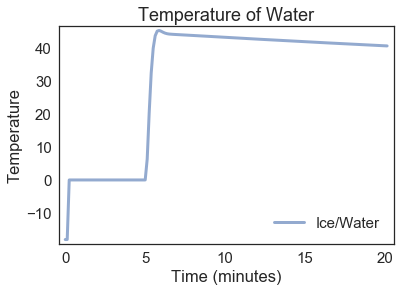

In [150]:
plot(Water.newResults.temp, label='Ice/Water')
decorate(xlabel='Time (minutes)',
         ylabel='Temperature',
         title='Temperature of Water')

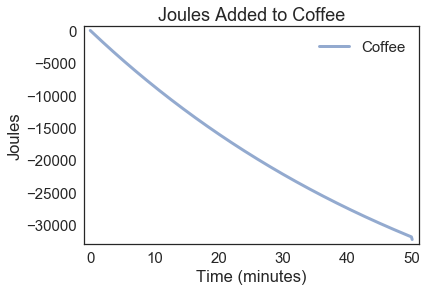

In [140]:
plot(Coffee.results.nrg, label='Coffee')
decorate(xlabel='Time (minutes)',
         ylabel='Joules',
         title='Joules Added to Coffee')

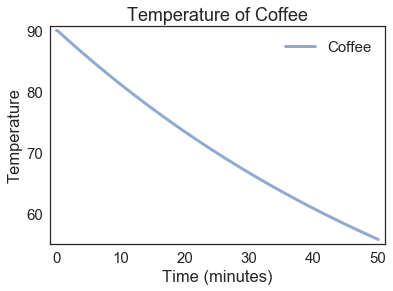

In [144]:
plot(Coffee.newResults.temp, label='Coffee')
decorate(xlabel='Time (minutes)',
         ylabel='Temperature',
         title='Temperature of Coffee')

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


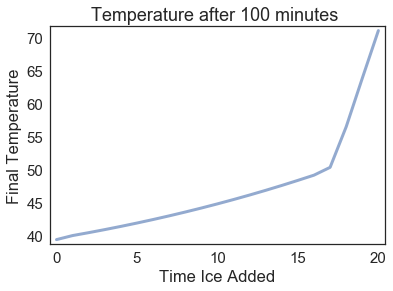

In [134]:
plot(sweep)
decorate(xlabel='Time Ice Added',
         ylabel='Final Temperature',
         title = 'Temperature after 100 minutes ')

In [109]:
print (Water.newResults.loc[6].temp)

111.439464863
